In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as PathEffects
from datetime import datetime, timedelta
import math
import os
import sys
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from pyproj import Geod

# Create output directories
os.makedirs('plots', exist_ok=True)
os.makedirs('maps', exist_ok=True)
os.makedirs('clustering_results', exist_ok=True)

In [133]:
def load_data(file_path):
    """
    Load tremor event data from CSV file and convert starttime to datetime.
    
    Args:
        file_path (str): Path to the tremor events CSV file
        
    Returns:
        pandas.DataFrame: Loaded tremor data
    """
    print(f"Loading tremor events data from {file_path}...")
    tremor_data = pd.read_csv(file_path)
    
    # Convert starttime to datetime
    tremor_data['starttime'] = pd.to_datetime(tremor_data['starttime'])
    
    return tremor_data

def filter_data(tremor_data, lat_min=44.4, lat_max=44.6): #44.4
    """
    Filter tremor data based on latitude range.
    
    Args:
        tremor_data (pandas.DataFrame): Tremor event data
        lat_min (float): Minimum latitude
        lat_max (float): Maximum latitude
        
    Returns:
        pandas.DataFrame: Filtered tremor data
    """
    #print(f"Filtering events between latitudes {lat_min} and {lat_max}...")
    filtered_data = tremor_data[(tremor_data['lat'] >= lat_min) & (tremor_data['lat'] <= lat_max)]
    filtered_data = filtered_data.sort_values('starttime')
    #print(f"Found {len(filtered_data)} events between latitudes {lat_min} and {lat_max}")
    
    # Save filtered data
    filtered_data.to_csv('filtered_tremor_data.csv', index=False)
    
    return filtered_data

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two points using Haversine formula.
    
    Args:
        lat1, lon1 (float): Latitude and longitude of first point
        lat2, lon2 (float): Latitude and longitude of second point
        
    Returns:
        float: Distance in kilometers
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    # Radius of Earth in kilometers
    radius = 6371.0
    distance = radius * c
    
    return distance

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate bearing between two points.
    
    Args:
        lat1, lon1 (float): Latitude and longitude of first point
        lat2, lon2 (float): Latitude and longitude of second point
        
    Returns:
        float: Bearing in degrees (0-360)
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Calculate bearing
    dlon = lon2_rad - lon1_rad
    y = math.sin(dlon) * math.cos(lat2_rad)
    x = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(dlon)
    bearing_rad = math.atan2(y, x)
    
    # Convert bearing from radians to degrees
    bearing_deg = math.degrees(bearing_rad)
    # Normalize to 0-360 degrees
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

def create_time_bins(filtered_data, bin_days=7):
    """
    Create time bins and count events in each bin.
    
    Args:
        filtered_data (pandas.DataFrame): Filtered tremor data
        bin_days (int): Number of days per bin
        
    Returns:
        tuple: (bin_counts, peak_bins) DataFrames with bin information
    """
    print(f"Creating {bin_days}-day bins and counting events...")
    min_date = filtered_data['starttime'].min().floor('D')
    max_date = filtered_data['starttime'].max().ceil('D')
    bin_edges = pd.date_range(start=min_date, end=max_date, freq=f'{bin_days}D')
    bin_labels = [bin_edges[i].strftime('%Y-%m-%d') for i in range(len(bin_edges)-1)]
    
    # Assign each event to a bin
    filtered_data['bin'] = pd.cut(filtered_data['starttime'], bins=bin_edges, labels=bin_labels, right=False)
    
    # Count events in each bin
    bin_counts = filtered_data['bin'].value_counts().sort_index()
    bin_counts = bin_counts.reset_index()
    bin_counts.columns = ['bin_start', 'event_count']
    bin_counts['bin_start'] = pd.to_datetime(bin_counts['bin_start'])
    bin_counts['bin_end'] = bin_counts['bin_start'] + pd.Timedelta(days=bin_days)
    bin_counts['bin_center'] = bin_counts['bin_start'] + pd.Timedelta(days=bin_days/2)
    
    # Identify peaks with more than threshold events
    threshold = 180
    peak_bins = bin_counts[bin_counts['event_count'] > threshold]
    print(f"Found {len(peak_bins)} peaks with more than {threshold} events in {bin_days}-day bins")
    
    return bin_counts, peak_bins

def analyze_peak_migration(filtered_data: pd.DataFrame,
                           peak_bins: pd.DataFrame):
    """
    Analyse migration parameters and radiated energy for each tremor peak.

    Returns
    -------
    peak_migration_data : list[dict]
        One dict per peak with full details.
    peak_summary : pandas.DataFrame
        Table with one row per peak (CSV is also written to disk).
    """
    peak_migration_data = []

    # ------------------------------------------------------------
    # loop over peaks
    for _, peak in peak_bins.iterrows():
        bin_start, bin_end = peak['bin_start'], peak['bin_end']
        bin_label          = bin_start.strftime('%Y-%m-%d')

        peak_events = filtered_data.loc[
            (filtered_data['starttime'] >= bin_start) &
            (filtered_data['starttime'] <  bin_end)
        ].sort_values('starttime')

        # ----- migration speed & direction -----------------------
        migration_speeds, migration_dirs = [], []

        for i in range(1, len(peak_events)):
            p_ev, c_ev = peak_events.iloc[i-1], peak_events.iloc[i]

            # km travelled between consecutive tremors
            dist_km = haversine_distance(p_ev['lat'], p_ev['lon'],
                                         c_ev['lat'], c_ev['lon'])

            dt_hr   = (c_ev['starttime'] - p_ev['starttime']).total_seconds() / 3600
            if dt_hr > 0:
                migration_speeds.append(dist_km / dt_hr)

            migration_dirs.append(
                calculate_bearing(p_ev['lat'], p_ev['lon'],
                                  c_ev['lat'], c_ev['lon'])
            )

        # ----- NEW: radiated-energy total ------------------------
        total_energy = peak_events['energy'].sum()   # joules (or whatever units)

        # store everything
        peak_migration_data.append({
            'bin_start'            : bin_start,
            'bin_end'              : bin_end,
            'bin_label'            : bin_label,
            'event_count'          : len(peak_events),
            'avg_migration_speed'  : np.mean(migration_speeds) if migration_speeds else np.nan,
            'avg_migration_direction': np.mean(migration_dirs)  if migration_dirs  else np.nan,
            'total_energy'         : total_energy,
            'migration_speeds'     : migration_speeds,
            'migration_directions' : migration_dirs,
            'peak_events'          : peak_events
        })

    # ------------------------------------------------------------
    # summary table (one row per peak)
    peak_summary = pd.DataFrame({
        'bin_start'             : [p['bin_start']           for p in peak_migration_data],
        'bin_end'               : [p['bin_end']             for p in peak_migration_data],
        'bin_label'             : [p['bin_label']           for p in peak_migration_data],
        'event_count'           : [p['event_count']         for p in peak_migration_data],
        'avg_migration_speed'   : [p['avg_migration_speed'] for p in peak_migration_data],
        'avg_migration_direction':[p['avg_migration_direction'] for p in peak_migration_data],
        'total_energy'          : [p['total_energy']        for p in peak_migration_data],
    })

    peak_summary.to_csv('peak_migration_summary.csv', index=False)
    return peak_migration_data, peak_summary


def plot_event_counts(bin_counts, peak_bins):
    """
    Plot event counts with peaks highlighted.
    
    Args:
        bin_counts (pandas.DataFrame): Counts of events in each bin
        peak_bins (pandas.DataFrame): Information about peak bins
    """
    plt.figure(figsize=(14, 6))
    plt.bar(bin_counts['bin_center'], bin_counts['event_count'], width=6, alpha=0.6, color='gray')
    #plt.bar(peak_bins['bin_center'], peak_bins['event_count'], width=6, alpha=0.8, color='red')
    
    peak_colours = ['green', 'blue', 'orange', 'orange', 'red', 'green','red','green','red','orange','red']  # <- add colors
    # make sure the list is as long as peak_bins
    if len(peak_colours) < len(peak_bins):
        raise ValueError("peak_colours must have at least as many entries as peak_bins")

    plt.bar(peak_bins['bin_center'],
            peak_bins['event_count'],
            width=6,
            alpha=0.8)
            #color=peak_colours[:len(peak_bins)])
    
    plt.xlabel('Date', fontsize=20)
    plt.title("Tremor Peaks > 180 Events", fontsize=20)
    plt.ylabel('Number of Events', fontsize=20)
    # Format x-axis to show dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.yticks(fontsize=20)
    plt.xticks(rotation=45, fontsize=20)
    plt.tight_layout()
    
    # Add a horizontal line at 200 events
    plt.axhline(y=180, color='black', linestyle='--', alpha=0.7)
    plt.text(bin_counts['bin_center'].iloc[0], 210, 'Threshold (180 events)', fontsize=10)
    
    plt.savefig('plots/event_counts_with_peaks.png', dpi=300)
    plt.close()

def plot_migration_speed(peak_summary):
    """
    Plot migration speed for each peak.
    
    Args:
        peak_summary (pandas.DataFrame): Summary of peak migration parameters
    """
    plt.figure(figsize=(14, 6))
    bars = plt.bar(peak_summary['bin_label'], peak_summary['avg_migration_speed'], alpha=0.7)
    
    # Color bars by event count
    event_counts = peak_summary['event_count']
    norm = plt.Normalize(event_counts.min(), event_counts.max())
    colors = plt.cm.viridis(norm(event_counts))
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
    
    plt.xlabel('Peak Period (Start Date)')
    plt.ylabel('Average Migration Speed (km/hour)')
    plt.title('Migration Speed for Peak Tremor Events (>200 Events in 7-day Bins)')
    plt.xticks(rotation=45)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Event Count')
    
    plt.tight_layout()
    plt.savefig('plots/peak_migration_speeds.png', dpi=300)
    plt.close()

def plot_migration_direction(peak_summary):
    """
    Plot migration direction for each peak.
    
    Args:
        peak_summary (pandas.DataFrame): Summary of peak migration parameters
    """
    plt.figure(figsize=(14, 6))
    bars = plt.bar(peak_summary['bin_label'], peak_summary['avg_migration_direction'], alpha=0.7)
    
    # Color bars by migration speed
    speeds = peak_summary['avg_migration_speed']
    norm = plt.Normalize(speeds.min(), speeds.max())
    colors = plt.cm.plasma(norm(speeds))
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
    
    plt.xlabel('Peak Period (Start Date)')
    plt.ylabel('Average Migration Direction (degrees)')
    plt.title('Migration Direction for Peak Tremor Events (>200 Events in 7-day Bins)')
    plt.xticks(rotation=45)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Migration Speed (km/hour)')
    
    plt.tight_layout()
    plt.savefig('plots/peak_migration_directions.png', dpi=300)
    plt.close()

def plot_speed_vs_direction(peak_summary):
    """
    Create a scatter plot of migration speed vs. direction for each peak.
    
    Args:
        peak_summary (pandas.DataFrame): Summary of peak migration parameters
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        peak_summary['avg_migration_direction'], 
        peak_summary['avg_migration_speed'],
        c=peak_summary['event_count'],
        s=peak_summary['event_count']/5,  # Size points by event count
        cmap='viridis',
        alpha=0.7
    )
    
    plt.xlabel('Migration Direction (degrees)')
    plt.ylabel('Migration Speed (km/hour)')
    plt.title('Migration Speed vs. Direction for Peak Tremor Events')
    
    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Event Count')
    
    # Add annotations for each point
    for i, row in peak_summary.iterrows():
        plt.annotate(
            row['bin_label'],
            (row['avg_migration_direction'], row['avg_migration_speed']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )
    
    plt.tight_layout()
    plt.savefig('plots/speed_vs_direction_scatter.png', dpi=300)
    plt.close()

def plot_polar_directions(peak_summary):
    """
    Create a polar plot of migration directions.
    
    Args:
        peak_summary (pandas.DataFrame): Summary of peak migration parameters
    """
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, projection='polar')
    
    # Convert degrees to radians for polar plot
    directions_rad = np.radians(peak_summary['avg_migration_direction'])
    speeds = peak_summary['avg_migration_speed']
    counts = peak_summary['event_count']
    
    # Create scatter plot on polar axes
    scatter = ax.scatter(
        directions_rad, 
        speeds,
        c=counts,
        s=counts/5,
        cmap='viridis',
        alpha=0.7
    )
    
    # Set the direction labels
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_thetagrids([0, 45, 90, 135, 180, 225, 270, 315], 
                      labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, pad=0.1)
    cbar.set_label('Event Count')
    
    # Add annotations for each point
    for i, row in peak_summary.iterrows():
        direction_rad = np.radians(row['avg_migration_direction'])
        speed = row['avg_migration_speed']
        ax.annotate(
            row['bin_label'],
            (direction_rad, speed),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )
    
    plt.title('Migration Direction and Speed (Polar Plot)')
    plt.tight_layout()
    plt.savefig('plots/polar_migration_directions.png', dpi=300)
    plt.close()

def create_density_map(peak_events,resolution=50):
    """
    Create a 2D histogram (density map) for a peak cluster.
    
    Args:
        peak_events (pandas.DataFrame): Events for a specific peak
        resolution (int): Resolution of the density map
        
    Returns:
        tuple: (hist_normalized, lon_edges, lat_edges) for the density map
    """
    lon_min, lon_max = peak_events['lon'].min() - 0.01, peak_events['lon'].max() + 0.01
    lat_min, lat_max = peak_events['lat'].min() - 0.01, peak_events['lat'].max() + 0.01
    
    # Create bins for the 2D histogram
    lon_bins = np.linspace(lon_min, lon_max, resolution)
    lat_bins = np.linspace(lat_min, lat_max, resolution)
    
    # Create the 2D histogram
    hist, lon_edges, lat_edges = np.histogram2d(
        peak_events['lon'], peak_events['lat'], 
        bins=[lon_bins, lat_bins]
    )
    
    # Normalize the histogram
    hist_normalized = hist / hist.max()
    
    #print(f"Creating density map for {bin_label}: {np.sum(hist_normalized):.4f} total density")
    
    return hist_normalized, lon_edges, lat_edges



def extract_features_from_density_map(density_map):
    """
    Extract features from a density map for clustering.
    
    Args:
        density_map (numpy.ndarray): 2D density map
        
    Returns:
        numpy.ndarray: Feature vector
    """
    # Calculate basic statistics
    mean_density = np.mean(density_map)
    std_density = np.std(density_map)
    max_density = np.max(density_map)
    
    # Calculate the center of mass
    y_indices, x_indices = np.indices(density_map.shape)
    center_y = np.sum(y_indices * density_map) / np.sum(density_map)
    center_x = np.sum(x_indices * density_map) / np.sum(density_map)
    
    # Calculate spatial moments
    y_diff = y_indices - center_y
    x_diff = x_indices - center_x
    moment_y2 = np.sum(y_diff**2 * density_map) / np.sum(density_map)
    moment_x2 = np.sum(x_diff**2 * density_map) / np.sum(density_map)
    moment_xy = np.sum(y_diff * x_diff * density_map) / np.sum(density_map)
    
    # Calculate the number of hotspots (local maxima)
    from scipy import ndimage
    from skimage import feature
    local_max = feature.peak_local_max(density_map, min_distance=3)
    num_hotspots = len(local_max)
    
    # Calculate the area above certain thresholds
    area_10 = np.sum(density_map > 0.1)
    area_25 = np.sum(density_map > 0.25)
    area_50 = np.sum(density_map > 0.5)
    
    # Create a feature vector
    features = np.array([
        mean_density, std_density, max_density,
        center_y, center_x,
        moment_y2, moment_x2, moment_xy,
        num_hotspots,
        area_10, area_25, area_50
    ])
    
    return features

def create_map_visualizations(filtered_data, peak_summary):
    """
    Create map visualizations for each peak cluster.
    
    Args:
        filtered_data (pandas.DataFrame): Filtered tremor data
        peak_summary (pandas.DataFrame): Summary of peak migration parameters
    """
    # Create a custom colormap for time progression
    colors = [(0, 0, 0.8), (0, 0.8, 0), (0.8, 0.8, 0), (0.8, 0, 0)]  # Blue -> Green -> Yellow -> Red
    cmap_name = 'time_progression'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    print(f"Creating map visualizations for {len(peak_summary)} peak clusters...")
    
    # Process each peak
    for i, peak in peak_summary.iterrows():
        bin_start = peak['bin_start']
        bin_end = peak['bin_end']
        bin_label = peak['bin_label']
        
        print(f"Processing peak {i+1}/{len(peak_summary)}: {bin_label}")
        
        # Extract events for this peak
        peak_events = filtered_data[(filtered_data['starttime'] >= bin_start) & 
                                   (filtered_data['starttime'] < bin_end)]
        
        # Sort by starttime
        peak_events = peak_events.sort_values('starttime')
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # First plot: Scatter plot with basemap
        scatter = ax1.scatter(
            peak_events['lon'], 
            peak_events['lat'],
            c=range(len(peak_events)),  # Color by event order
            cmap=cm,
            alpha=0.7,
            s=50,
            zorder=3
        )
        

        ax1.set_facecolor('#f2f2f2')
        
        # Connect events with lines to show migration path
        ax1.plot(peak_events['lon'], peak_events['lat'], 'k-', alpha=0.3, zorder=2)
        
        # Add first and last event markers
        ax1.plot(peak_events['lon'].iloc[0], peak_events['lat'].iloc[0], 'o', 
                 color='blue', markersize=12, markeredgecolor='black', zorder=4)
        ax1.plot(peak_events['lon'].iloc[-1], peak_events['lat'].iloc[-1], 'o', 
                 color='red', markersize=12, markeredgecolor='black', zorder=4)
        
        # Add text labels with white outline for visibility
        start_txt = ax1.text(peak_events['lon'].iloc[0] + 0.01, peak_events['lat'].iloc[0] + 0.01, 
                             'Start', fontsize=12, color='white', fontweight='bold', zorder=5)
        start_txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
        
        end_txt = ax1.text(peak_events['lon'].iloc[-1] + 0.01, peak_events['lat'].iloc[-1] + 0.01, 
                           'End', fontsize=12, color='white', fontweight='bold', zorder=5)
        end_txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
        
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_title(f'Tremor Events Map: {bin_label} to {bin_end.strftime("%Y-%m-%d")}')
        
        # Add colorbar for time progression
        cbar = fig.colorbar(scatter, ax=ax1)
        cbar.set_label('Event Sequence (Time Progression)')
        
        # Add text with migration parameters
        textstr = (f'Event Count: {peak["event_count"]}\n'
                   f'Avg Migration Speed: {peak["avg_migration_speed"]:.2f} km/h\n'
                   f'Avg Migration Direction: {peak["avg_migration_direction"]:.2f}°')
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax1.text(0.05, 0.05, textstr, transform=ax1.transAxes, fontsize=12,
                 verticalalignment='bottom', bbox=props)
        
        # Second plot: Heatmap with basemap
        # Create a 2D histogram
        lon_bins = np.linspace(peak_events['lon'].min() - 0.01, peak_events['lon'].max() + 0.01, 50)
        lat_bins = np.linspace(peak_events['lat'].min() - 0.01, peak_events['lat'].max() + 0.01, 50)
        
        hist, lon_edges, lat_edges = np.histogram2d(
            peak_events['lon'], peak_events['lat'], 
            bins=[lon_bins, lat_bins]
        )
        
        # Plot the heatmap
        lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
        lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
        lon_mesh, lat_mesh = np.meshgrid(lon_centers, lat_centers)
        
        heatmap = ax2.pcolormesh(lon_mesh, lat_mesh, hist.T, cmap='hot', alpha=0.7, zorder=3)
        
        ax2.set_facecolor('#f2f2f2')
        
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        ax2.set_title(f'Tremor Event Density: {bin_label} to {bin_end.strftime("%Y-%m-%d")}')
        
        # Add colorbar for heatmap
        cbar2 = fig.colorbar(heatmap, ax=ax2)
        cbar2.set_label('Event Density')
        
        # Ensure both plots have the same extent
        xlim = [min(peak_events['lon'].min() - 0.02, lon_edges.min()), 
                max(peak_events['lon'].max() + 0.02, lon_edges.max())]
        ylim = [min(peak_events['lat'].min() - 0.02, lat_edges.min()), 
                max(peak_events['lat'].max() + 0.02, lat_edges.max())]
        
        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)
        ax2.set_xlim(xlim)
        ax2.set_ylim(ylim)
        
        plt.tight_layout()
        plt.savefig(f'maps/map_cluster_{bin_label}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Map visualizations complete. Results saved to maps directory.")

def perform_hierarchical_clustering(peak_summary, filtered_data, peak_migration_data):
    """
    Perform hierarchical clustering on peak clusters.
    
    Args:
        peak_summary (pandas.DataFrame): Summary of peak migration parameters
        filtered_data (pandas.DataFrame): Filtered tremor data
        peak_migration_data (list): Detailed migration data for each peak
        
    Returns:
        pandas.DataFrame: Clustering results
    """
    print("Performing hierarchical clustering on peak clusters...")
    
    # Process each peak to create density maps and extract features
    density_maps = []
    density_map_metadata = []  # Store lon/lat edges
    feature_vectors = []
    peak_labels = []
    
    for i, peak in peak_summary.iterrows():
        bin_start = peak['bin_start']
        bin_end = peak['bin_end']
        bin_label = peak['bin_label']
        
        print(f"Processing peak {i+1}/{len(peak_summary)}: {bin_label}")
        
        # Extract events for this peak
        peak_events = filtered_data[(filtered_data['starttime'] >= bin_start) & 
                                   (filtered_data['starttime'] < bin_end)]
        
        # Get spatial bounds
        lon_min, lon_max = peak_events['lon'].min(), peak_events['lon'].max()
        lat_min, lat_max = peak_events['lat'].min(), peak_events['lat'].max()

        print(f"Peak {bin_label}: Lon ({lon_min:.4f}, {lon_max:.4f}) | Lat ({lat_min:.4f}, {lat_max:.4f})")
        
        # Create density map
        density_map, lon_edges, lat_edges = create_density_map(peak_events)#, bin_label)
        density_maps.append(density_map)
        density_map_metadata.append((lon_edges, lat_edges))  # Store bin edges
        
        # Extract features
        features = extract_features_from_density_map(density_map)
        
        # Store results
        density_maps.append(density_map)
        feature_vectors.append(features)
        peak_labels.append(bin_label)
    
    # Convert feature vectors to a numpy array
    feature_array = np.array(feature_vectors)
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_array)
    
    # Apply PCA for dimensionality reduction and visualization
    pca = PCA(n_components=min(len(peak_summary) - 1, 5))
    pca_result = pca.fit_transform(scaled_features)
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")
    
    # Create a figure to visualize PCA results
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], s=100)
    
    # Add labels for each point
    for i, label in enumerate(peak_labels):
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), 
                     fontsize=9, ha='center')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
    plt.title('PCA of Density Map Features')
    plt.grid(True, alpha=0.3)
    plt.savefig('clustering_results/pca_visualization.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Perform hierarchical clustering
    # Calculate distance matrix
    dist_matrix = pdist(scaled_features, metric='euclidean')
    
    # Perform hierarchical clustering with different linkage methods
    linkage_methods = ['single', 'complete', 'average', 'ward']
    linkage_results = {}
    
    for method in linkage_methods:
        linkage_results[method] = linkage(scaled_features, method=method)
    
    # Create dendrograms for each linkage method
    plt.figure(figsize=(20, 15))
    
    for i, method in enumerate(linkage_methods):
        plt.subplot(2, 2, i+1)
        dendrogram(linkage_results[method], labels=peak_labels, orientation='top', leaf_font_size=9)
        plt.title(f'Hierarchical Clustering Dendrogram ({method} linkage)')
        plt.xlabel('Peak Clusters')
        plt.ylabel('Distance')
    
    plt.tight_layout()
    plt.savefig('clustering_results/dendrograms_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Determine optimal number of clusters using silhouette score
    silhouette_scores = []
    K_range = range(2, min(6, len(peak_summary)))
    
    # Use ward linkage for final clustering
    Z = linkage_results['ward']
    
    for k in K_range:
        # Get cluster labels
        cluster_labels = fcluster(Z, k, criterion='maxclust')
        
        if len(set(cluster_labels)) > 1:  # Ensure we have at least 2 clusters
            score = silhouette_score(scaled_features, cluster_labels)
            silhouette_scores.append(score)
            print(f"Silhouette score for k={k}: {score:.3f}")
        else:
            silhouette_scores.append(0)
            print(f"Only one cluster found for k={k}")
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(K_range), silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.grid(True, alpha=0.3)
    plt.savefig('clustering_results/silhouette_scores.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Choose optimal k based on silhouette score
    if silhouette_scores:
        optimal_k = list(K_range)[np.argmax(silhouette_scores)]
    else:
        optimal_k = 2  # Default if silhouette scores couldn't be calculated
    
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
    
    # Get final cluster labels
    hierarchical_labels = fcluster(Z, optimal_k, criterion='maxclust')
    
    # Create a DataFrame to store clustering results
    clustering_results = pd.DataFrame({
        'peak_label': peak_labels,
        'hierarchical_cluster': hierarchical_labels,
        'avg_migration_speed': peak_summary['avg_migration_speed'].values,
        'avg_migration_direction': peak_summary['avg_migration_direction'].values,
        'event_count': peak_summary['event_count'].values
    })
    
    # Save clustering results
    clustering_results.to_csv('clustering_results/hierarchical_clustering_results.csv', index=False)
    
    print("Clustering results:")
    print(clustering_results)
    
    # Create a detailed dendrogram for the final clustering
    plt.figure(figsize=(12, 6))
    dendrogram(
        Z,
        labels=peak_labels,
        orientation='top',
        leaf_font_size=9,
        color_threshold=Z[-(optimal_k-1), 2]  # Color threshold to show optimal_k clusters
    )
    plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
    plt.xlabel('Peak Clusters', fontsize=16)
    plt.ylabel('Distance', fontsize=16)
    plt.xticks(rotation=45, ha='right',fontsize=12)
    plt.yticks(fontsize=12)
    x_labels = plt.gca().get_xticklabels()

    # Make the 6th and 7th labels bold (indices 5 and 6 are the 6th and 7th, 0-based)
    x_labels[5].set_fontweight('bold')
    x_labels[6].set_fontweight('bold')

    # Assign them back to the axis
    plt.gca().set_xticklabels(x_labels)
    
    # Add a horizontal line at the cut threshold
    plt.axhline(y=Z[-(optimal_k-1), 2], color='r', linestyle='--')
    plt.text(0, Z[-(optimal_k-1), 2] * 1.05, f'Cut threshold: {Z[-(optimal_k-1), 2]:.2f}', color='r')
    
    plt.savefig('clustering_results/final_dendrogram.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Visualize clustering results in PCA space
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        pca_result[:, 0], 
        pca_result[:, 1], 
        c=hierarchical_labels, 
        cmap='viridis', 
        s=100, 
        alpha=0.8
    )
    
    # Add labels for each point
    for i, label in enumerate(peak_labels):
        plt.annotate(
            label, 
            (pca_result[i, 0], pca_result[i, 1]), 
            fontsize=9, 
            ha='center', 
            va='bottom',
            xytext=(0, 5), 
            textcoords='offset points'
        )
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
    plt.title('Hierarchical Clustering Results')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.savefig('clustering_results/hierarchical_clustering_pca.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Analyze cluster characteristics
    cluster_stats = clustering_results.groupby('hierarchical_cluster').agg({
        'peak_label': ['count', list],
        'avg_migration_speed': ['mean', 'std', 'min', 'max'],
        'avg_migration_direction': ['mean', 'std', 'min', 'max'],
        'event_count': ['mean', 'std', 'min', 'max']
    }).reset_index()
    
    # Flatten the multi-level column names
    cluster_stats.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in cluster_stats.columns]
    
    # Save cluster statistics
    cluster_stats.to_csv('clustering_results/hierarchical_cluster_statistics.csv', index=False)
    
    print("Cluster statistics:")
    for i, row in cluster_stats.iterrows():
        print(f"Cluster {row['hierarchical_cluster']}: {row['peak_label_count']} peaks")
        print(f"  Peaks: {', '.join(row['peak_label_list'])}")
        print(f"  Avg migration speed: {row['avg_migration_speed_mean']:.2f} km/h (±{row['avg_migration_speed_std']:.2f})")
        print(f"  Avg migration direction: {row['avg_migration_direction_mean']:.2f}° (±{row['avg_migration_direction_std']:.2f})")
        print(f"  Avg event count: {row['event_count_mean']:.1f} (±{row['event_count_std']:.1f})")
        print()
    ###########################################################################################
    # Visualize representative density maps for each cluster
    for cluster_id in range(1, optimal_k + 1):  # Cluster IDs start from 1
        # Get indices of peaks in this cluster
        cluster_indices = np.where(hierarchical_labels == cluster_id)[0]

        if len(cluster_indices) == 0:
            continue

        # Create a figure for this cluster
        fig_width = min(20, 5 * len(cluster_indices))  # Limit width for many maps
        fig, axes = plt.subplots(1, len(cluster_indices), figsize=(fig_width, 5))

        # Handle the case where there's only one map in the cluster
        if len(cluster_indices) == 1:
            axes = [axes]

        # Plot each density map in this cluster
        for i, idx in enumerate(cluster_indices):
            axes[i].imshow(density_maps[idx], cmap='hot', origin='lower')
            axes[i].set_title(f"{peak_labels[idx]}\nCluster {cluster_id}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig(f'clustering_results/cluster_{cluster_id}_density_maps.png', dpi=300, bbox_inches='tight')
        plt.close()

    
    
    # Create a visualization comparing migration parameters between clusters
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Migration Speed by Cluster
    plt.subplot(2, 2, 1)
    for cluster_id in range(1, optimal_k + 1):
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster_id]
        plt.scatter(
            cluster_data['peak_label'], 
            cluster_data['avg_migration_speed'],
            label=f'Cluster {cluster_id}',
            s=80,
            alpha=0.7
        )
    
    plt.xlabel('Peak Period')
    plt.ylabel('Migration Speed (km/h)')
    plt.title('Migration Speed by Cluster')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Migration Direction by Cluster
    plt.subplot(2, 2, 2)
    for cluster_id in range(1, optimal_k + 1):
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster_id]
        plt.scatter(
            cluster_data['peak_label'], 
            cluster_data['avg_migration_direction'],
            label=f'Cluster {cluster_id}',
            s=80,
            alpha=0.7
        )
    
    plt.xlabel('Peak Period')
    plt.ylabel('Migration Direction (degrees)')
    plt.title('Migration Direction by Cluster')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Event Count by Cluster
    plt.subplot(2, 2, 3)
    for cluster_id in range(1, optimal_k + 1):
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster_id]
        plt.scatter(
            cluster_data['peak_label'], 
            cluster_data['event_count'],
            label=f'Cluster {cluster_id}',
            s=80,
            alpha=0.7
        )
    
    plt.xlabel('Peak Period')
    plt.ylabel('Event Count')
    plt.title('Event Count by Cluster')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Migration Speed vs Direction by Cluster
    plt.subplot(2, 2, 4)
    for cluster_id in range(1, optimal_k + 1):
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster_id]
        plt.scatter(
            cluster_data['avg_migration_direction'], 
            cluster_data['avg_migration_speed'],
            label=f'Cluster {cluster_id}',
            s=cluster_data['event_count'] / 5,  # Size by event count
            alpha=0.7
        )
    
    plt.xlabel('Migration Direction (degrees)')
    plt.ylabel('Migration Speed (km/h)')
    plt.title('Migration Speed vs Direction by Cluster')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('clustering_results/cluster_parameter_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a polar plot showing migration parameters by cluster
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection='polar')
    
    # Plot each cluster with a different color
    for cluster_id in range(1, optimal_k + 1):
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster_id]
        
        # Convert degrees to radians for polar plot
        directions_rad = np.radians(cluster_data['avg_migration_direction'])
        speeds = cluster_data['avg_migration_speed']
        counts = cluster_data['event_count']
        
        ax.scatter(
            directions_rad, 
            speeds,
            label=f'Cluster {cluster_id}',
            s=counts / 5,  # Size by event count
            alpha=0.7
        )
        
        # Add labels for each point
        for i, row in cluster_data.iterrows():
            direction_rad = np.radians(row['avg_migration_direction'])
            ax.annotate(
                row['peak_label'],
                (direction_rad, row['avg_migration_speed']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8
            )
    
    # Set the direction labels
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_thetagrids([0, 45, 90, 135, 180, 225, 270, 315], 
                      labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    plt.title('Migration Parameters by Cluster (Polar Plot)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.tight_layout()
    plt.savefig('clustering_results/polar_cluster_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Hierarchical clustering analysis complete. Results saved to clustering_results directory.")
    
    return clustering_results, density_maps, peak_labels, hierarchical_labels, optimal_k,features


def plot_peak_energy_and_counts(peak_summary, log_energy=False):
    """
    Bar-chart of (1) total radiated energy and (2) event count per peak.

    Parameters
    ----------
    peak_summary : pandas.DataFrame   # must contain bin_start, bin_label,
                                      # total_energy, event_count
    log_energy   : bool, optional     # log-scale the energy axis
    """
    ps = peak_summary.sort_values('bin_start')

    x   = np.arange(len(ps))                 # numeric x positions
    wid = 0.4                                # bar width

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # -------- left axis: total energy ------------
    ax1.bar(x - wid/2, ps['total_energy'],
            width=wid, color='royalblue', alpha=0.8, label='Total energy')
    ax1.set_ylabel('Radiated energy (J)')
    if log_energy:
        ax1.set_yscale('log')
        ax1.set_ylabel('Radiated energy (J, log scale)')

    # -------- right axis: event count ------------
    ax2 = ax1.twinx()
    ax2.bar(x + wid/2, ps['event_count'],
            width=wid, color='salmon', alpha=0.8, label='Event count')
    ax2.set_ylabel('Event count')

    # -------- cosmetics --------------------------
    ax1.set_xticks(x)
    ax1.set_xticklabels(ps['bin_label'], rotation=45, ha='right')
    ax1.set_xlabel('Peak (bin label)')
    ax1.set_title('Radiated energy and event count per tremor peak')

    # combine legends from both axes
    handles, labels = [], []
    for ax in (ax1, ax2):
        h, l = ax.get_legend_handles_labels()
        handles += h; labels += l
    ax1.legend(handles, labels, loc='upper right')

    plt.tight_layout()
    plt.show()


In [134]:
"""Main function to run the hierarchical clustering analysis."""
# Check if a file path was provided as a command-line argument
file_path = '/home/seismic/tremor_events-2009-08-10T00_00_00-2025-03-17T23_59_59.csv'

# Load and preprocess data
tremor_data = load_data(file_path)
filtered_data = filter_data(tremor_data)

# Create time bins and analyze peaks
bin_counts, peak_bins = create_time_bins(filtered_data)
peak_migration_data, peak_summary = analyze_peak_migration(filtered_data, peak_bins)

# Create basic visualizations
plot_event_counts(bin_counts, peak_bins)
plot_migration_speed(peak_summary)
plot_migration_direction(peak_summary)
plot_speed_vs_direction(peak_summary)
plot_polar_directions(peak_summary)

# Create map visualizations
create_map_visualizations(filtered_data, peak_summary)

# Perform hierarchical clustering
clustering_results, density_maps, peak_labels, hierarchical_labels, optimal_k,lon_edges = perform_hierarchical_clustering(
    peak_summary, filtered_data, peak_migration_data
)

print("Hierarchical clustering analysis complete!")
print(f"- {len(filtered_data)} tremor events analyzed")
print(f"- {len(peak_summary)} peak periods identified")
print(f"- {optimal_k} hierarchical clusters created")
print(f"- Results saved to plots/, maps/, and clustering_results/ directories")

Loading tremor events data from /home/seismic/tremor_events-2009-08-10T00_00_00-2025-03-17T23_59_59.csv...


/tmp/ipykernel_726593/2778640539.py:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor_data = pd.read_csv(file_path)


Creating 7-day bins and counting events...
Found 11 peaks with more than 180 events in 7-day bins
Creating map visualizations for 11 peak clusters...
Processing peak 1/11: 2009-09-02
Processing peak 2/11: 2011-06-08
Processing peak 3/11: 2013-03-06
Processing peak 4/11: 2016-02-03
Processing peak 5/11: 2017-12-06
Processing peak 6/11: 2019-05-15
Processing peak 7/11: 2021-04-14
Processing peak 8/11: 2022-10-12
Processing peak 9/11: 2024-04-17
Processing peak 10/11: 2024-04-24
Processing peak 11/11: 2024-10-02
Map visualizations complete. Results saved to maps directory.
Performing hierarchical clustering on peak clusters...
Processing peak 1/11: 2009-09-02
Peak 2009-09-02: Lon (-123.9400, -122.6300) | Lat (44.4000, 44.6000)
Processing peak 2/11: 2011-06-08
Peak 2011-06-08: Lon (-123.7800, -123.2250) | Lat (44.4000, 44.6000)
Processing peak 3/11: 2013-03-06
Peak 2013-03-06: Lon (-123.8350, -123.1800) | Lat (44.4000, 44.6000)
Processing peak 4/11: 2016-02-03
Peak 2016-02-03: Lon (-123.92

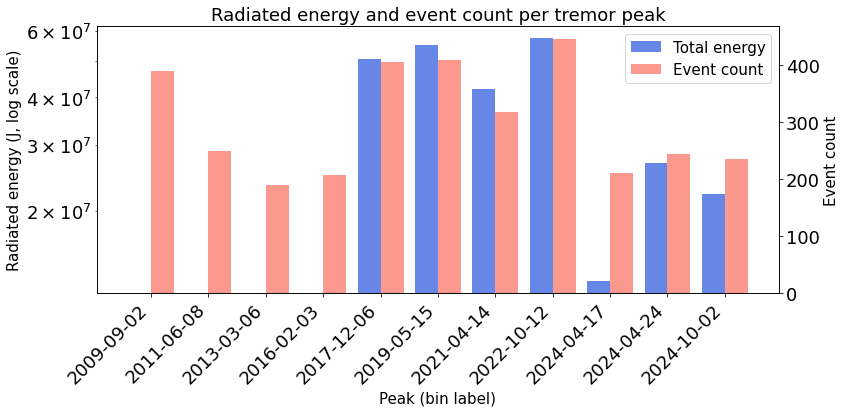

In [132]:
plot_peak_energy_and_counts(peak_summary, log_energy=True)

In [121]:
# Create output directory for enhanced visualizations
os.makedirs('enhanced_visualizations', exist_ok=True)

def load_clustering_results(file_path='clustering_results/hierarchical_clustering_results.csv'):
    """
    Load hierarchical clustering results from CSV file.
    
    Args:
        file_path (str): Path to the clustering results CSV file
        
    Returns:
        pandas.DataFrame: Loaded clustering results
    """
    print(f"Loading clustering results from {file_path}...")
    clustering_results = pd.read_csv(file_path)
    return clustering_results

def load_tremor_data(file_path='filtered_tremor_data.csv'):
    """
    Load filtered tremor data from CSV file.
    
    Args:
        file_path (str): Path to the filtered tremor data CSV file
        
    Returns:
        pandas.DataFrame: Loaded tremor data
    """
    print(f"Loading tremor data from {file_path}...")
    tremor_data = pd.read_csv(file_path)
    tremor_data['starttime'] = pd.to_datetime(tremor_data['starttime'])
    return tremor_data

def create_cluster_comparison_heatmap(clustering_results):
    """
    Create a heatmap comparing cluster characteristics.
    
    Args:
        clustering_results (pandas.DataFrame): Clustering results
    """
    # Group by cluster and calculate statistics
    cluster_stats = clustering_results.groupby('hierarchical_cluster').agg({
        'avg_migration_speed': ['mean', 'std', 'min', 'max'],
        'avg_migration_direction': ['mean', 'std', 'min', 'max'],
        'event_count': ['mean', 'std', 'min', 'max']
    })
    
    # Flatten the multi-level column names
    cluster_stats.columns = ['_'.join(col) for col in cluster_stats.columns]
    
    # Extract the mean values for heatmap
    heatmap_data = cluster_stats[[
        'avg_migration_speed_mean', 
        'avg_migration_direction_mean', 
        'event_count_mean'
    ]]
    
    # Normalize the data for better visualization
    normalized_data = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_data.T, cmap='viridis', aspect='auto')
    
    # Add labels
    plt.yticks(range(len(normalized_data.columns)), [
        'Migration Speed', 
        'Migration Direction', 
        'Event Count'
    ])
    plt.xticks(range(len(normalized_data)), [f'Cluster {i}' for i in normalized_data.index])
    
    # Add values in cells
    for i in range(len(normalized_data)):
        for j in range(len(normalized_data.columns)):
            plt.text(
                i, j, 
                f"{heatmap_data.iloc[i, j]:.2f}", 
                ha="center", va="center", 
                color="white" if normalized_data.iloc[i, j] > 0.5 else "black"
            )
    
    plt.colorbar(label='Normalized Value')
    plt.title('Cluster Characteristics Comparison')
    plt.tight_layout()
    plt.savefig('enhanced_visualizations/cluster_comparison_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()


def create_3d_cluster_visualization(clustering_results):
    """
    Create a 3D visualization of clusters based on migration parameters.
    
    Args:
        clustering_results (pandas.DataFrame): Clustering results
    """
    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique clusters
    clusters = sorted(clustering_results['hierarchical_cluster'].unique())
    
    # Create a color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
    
    # Plot each cluster
    for i, cluster in enumerate(clusters):
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster]
        
        # Plot 3D scatter
        scatter = ax.scatter(
            cluster_data['avg_migration_speed'],
            cluster_data['avg_migration_direction'],
            cluster_data['event_count'],
            s=80,
            color=colors[i],
            alpha=0.7,
            label=f'Cluster {cluster}'
        )
        
        # Add labels for each point
        for _, row in cluster_data.iterrows():
            ax.text(
                row['avg_migration_speed'],
                row['avg_migration_direction'],
                row['event_count'],
                row['peak_label'],
                fontsize=8
            )
    
    ax.set_xlabel('Migration Speed (km/h)')
    ax.set_ylabel('Migration Direction (degrees)')
    ax.set_zlabel('Event Count')
    ax.set_title('3D Visualization of Clusters')
    plt.legend()
    plt.tight_layout()
    plt.savefig('enhanced_visualizations/3d_cluster_visualization.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_radar_chart(clustering_results):
    """
    Create radar charts for each cluster showing key characteristics.
    
    Args:
        clustering_results (pandas.DataFrame): Clustering results
    """
    # Group by cluster and calculate statistics
    cluster_stats = clustering_results.groupby('hierarchical_cluster').agg({
        'avg_migration_speed': 'mean',
        'avg_migration_direction': 'mean',
        'event_count': 'mean'
    })
    
    # Normalize the data for radar chart
    normalized_stats = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())
    
    # Define categories for radar chart
    categories = ['Migration Speed', 'Migration Direction', 'Event Count']
    
    # Get unique clusters
    clusters = sorted(cluster_stats.index)
    
    # Create a color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
    
    # Create radar chart
    fig = plt.figure(figsize=(12, 10))
    
    # Plot each cluster as a separate radar chart
    for i, cluster in enumerate(clusters):
        # Create subplot in a grid
        ax = fig.add_subplot(2, (len(clusters) + 1) // 2, i + 1, polar=True)
        
        # Get normalized values for this cluster
        values = normalized_stats.loc[cluster].values
        
        # Close the loop by repeating the first value
        values = np.append(values, values[0])
        
        # Set the angles for each category (evenly spaced)
        angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
        
        # Close the loop by repeating the first angle
        angles = np.append(angles, angles[0])
        
        # Plot the radar chart
        ax.plot(angles, values, color=colors[i], linewidth=2)
        ax.fill(angles, values, color=colors[i], alpha=0.25)
        
        # Set the labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        
        # Set title
        ax.set_title(f'Cluster {cluster}', size=11)
        
        # Add actual values as text
        for j, category in enumerate(categories):
            value = cluster_stats.loc[cluster][j]
            ax.annotate(
                f'{value:.2f}',
                (angles[j], values[j]),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=8
            )
    
    plt.tight_layout()
    plt.savefig('enhanced_visualizations/cluster_radar_charts.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_map_comparison(clustering_results, tremor_data):
    """
    Create maps comparing spatial distribution of events across clusters.
    
    Args:
        clustering_results (pandas.DataFrame): Clustering results
        tremor_data (pandas.DataFrame): Filtered tremor data
    """
    # Get unique clusters
    clusters = sorted(clustering_results['hierarchical_cluster'].unique())
    
    # Create a figure with subplots for each cluster
    fig, axes = plt.subplots(1, len(clusters), figsize=(6*len(clusters), 6))
    
    # Handle case with only one cluster
    if len(clusters) == 1:
        axes = [axes]
    
    # Create a custom colormap for time progression
    colors = [(0, 0, 0.8), (0, 0.8, 0), (0.8, 0.8, 0), (0.8, 0, 0)]  # Blue -> Green -> Yellow -> Red
    cmap_name = 'time_progression'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    # Plot each cluster
    for i, cluster in enumerate(clusters):
        ax = axes[i]
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster]
        
        # Combine all events from peaks in this cluster
        all_cluster_events = pd.DataFrame()
        
        for _, row in cluster_data.iterrows():
            peak_label = row['peak_label']
            peak_date = pd.to_datetime(peak_label)
            peak_end = peak_date + pd.Timedelta(days=7)
            
            # Extract events for this peak
            peak_events = tremor_data[(tremor_data['starttime'] >= peak_date) & 
                                     (tremor_data['starttime'] < peak_end)]
            
            all_cluster_events = pd.concat([all_cluster_events, peak_events])
        
        # Plot events on map
        scatter = ax.scatter(
            all_cluster_events['lon'],
            all_cluster_events['lat'],
            c=range(len(all_cluster_events)),
            cmap=cm,
            alpha=0.5,
            s=30
        )
        ax.set_facecolor('#f2f2f2')
        
        # Set labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Cluster {cluster} Events\n({len(all_cluster_events)} events from {len(cluster_data)} peaks)')
        
        # Add text with cluster statistics
        textstr = (
            f'Avg Speed: {cluster_data["avg_migration_speed"].mean():.2f} km/h\n'
            f'Avg Direction: {cluster_data["avg_migration_direction"].mean():.2f}°\n'
            f'Avg Events: {cluster_data["event_count"].mean():.0f}'
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.savefig('enhanced_visualizations/cluster_map_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_migration_vectors(clustering_results, tremor_data):
    """
    Create visualizations showing migration vectors for each cluster.
    
    Args:
        clustering_results (pandas.DataFrame): Clustering results
        tremor_data (pandas.DataFrame): Filtered tremor data
    """
    # Get unique clusters
    clusters = sorted(clustering_results['hierarchical_cluster'].unique())
    
    # Create a figure with subplots for each cluster
    fig, axes = plt.subplots(1, len(clusters), figsize=(6*len(clusters), 6))
    
    # Handle case with only one cluster
    if len(clusters) == 1:
        axes = [axes]
    
    # Plot each cluster
    for i, cluster in enumerate(clusters):
        ax = axes[i]
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster]
        
        # Process each peak in this cluster
        for _, row in cluster_data.iterrows():
            peak_label = row['peak_label']
            peak_date = pd.to_datetime(peak_label)
            peak_end = peak_date + pd.Timedelta(days=7)
            
            # Extract events for this peak
            peak_events = tremor_data[(tremor_data['starttime'] >= peak_date) & 
                                     (tremor_data['starttime'] < peak_end)]
            
            # Sort by starttime
            peak_events = peak_events.sort_values('starttime')
            
            if len(peak_events) < 2:
                continue
            
            # Get first and last event
            first_event = peak_events.iloc[0]
            last_event = peak_events.iloc[-1]
            
            # Plot migration vector
            ax.arrow(
                first_event['lon'], first_event['lat'],
                last_event['lon'] - first_event['lon'],
                last_event['lat'] - first_event['lat'],
                head_width=0.02, head_length=0.03, fc='blue', ec='blue',
                length_includes_head=True, alpha=0.6
            )
            
            # Add label for the peak
            ax.annotate(
                peak_label,
                ((first_event['lon'] + last_event['lon'])/2, 
                 (first_event['lat'] + last_event['lat'])/2),
                fontsize=8
            )
        
        ax.set_facecolor('#f2f2f2')
        
        # Set labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Cluster {cluster} Migration Vectors\n({len(cluster_data)} peaks)')
        
        # Add text with cluster statistics
        textstr = (
            f'Avg Speed: {cluster_data["avg_migration_speed"].mean():.2f} km/h\n'
            f'Avg Direction: {cluster_data["avg_migration_direction"].mean():.2f}°\n'
            f'Avg Events: {cluster_data["event_count"].mean():.0f}'
        )
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('enhanced_visualizations/cluster_migration_vectors.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_event_density_comparison(clustering_results, tremor_data):
    """
    Create density heatmaps comparing event distribution across clusters.
    
    Args:
        clustering_results (pandas.DataFrame): Clustering results
        tremor_data (pandas.DataFrame): Filtered tremor data
    """
    # Get unique clusters
    clusters = sorted(clustering_results['hierarchical_cluster'].unique())
    
    # Create a figure with subplots for each cluster
    fig, axes = plt.subplots(1, len(clusters), figsize=(6*len(clusters), 6))
    plt.rcParams.update({'font.size': 15})
    # Handle case with only one cluster
    if len(clusters) == 1:
        axes = [axes]
    
    # Plot each cluster
    for i, cluster in enumerate(clusters):
        ax = axes[i]
        cluster_data = clustering_results[clustering_results['hierarchical_cluster'] == cluster]
        
        # Combine all events from peaks in this cluster
        all_cluster_events = pd.DataFrame()
        
        for _, row in cluster_data.iterrows():
            peak_label = row['peak_label']
            peak_date = pd.to_datetime(peak_label)
            peak_end = peak_date + pd.Timedelta(days=7)
            
            # Extract events for this peak
            peak_events = tremor_data[(tremor_data['starttime'] >= peak_date) & 
                                     (tremor_data['starttime'] < peak_end)]
            
            all_cluster_events = pd.concat([all_cluster_events, peak_events])
        
        if len(all_cluster_events) < 10:
            ax.text(0.5, 0.5, "Insufficient data", ha='center', va='center')
            continue
        
        # Create a 2D histogram (density map)
        lon_bins = np.linspace(all_cluster_events['lon'].min() - 0.01, all_cluster_events['lon'].max() + 0.01, 50)
        lat_bins = np.linspace(all_cluster_events['lat'].min() - 0.01, all_cluster_events['lat'].max() + 0.01, 50)
        
        hist, lon_edges, lat_edges = np.histogram2d(
            all_cluster_events['lon'], all_cluster_events['lat'], 
            bins=[lon_bins, lat_bins]
        )
        
        # Plot the heatmap
        lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
        lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
        lon_mesh, lat_mesh = np.meshgrid(lon_centers, lat_centers)
        
        heatmap = ax.pcolormesh(lon_mesh, lat_mesh, hist.T, cmap='hot')
        
        # Set labels and title
        ax.set_xlabel('Longitude',fontsize=15)
        ax.set_ylabel('Latitude',fontsize=15)
        ax.set_title(f'Cluster {cluster} Event Density\n({len(all_cluster_events)} events from {len(cluster_data)} peaks)')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        # Add colorbar
        plt.colorbar(heatmap, ax=ax, label='Event Count')
    
    plt.tight_layout()
    plt.savefig('enhanced_visualizations/cluster_density_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()



In [122]:
"""Main function to create enhanced visualizations for hierarchical clustering results."""
# Check if a file path was provided as a command-line argument
clustering_results_path = 'clustering_results/hierarchical_clustering_results.csv'

# Load clustering results
clustering_results = load_clustering_results(clustering_results_path)


tremor_data = load_tremor_data()


print("Creating enhanced visualizations for hierarchical clustering results...")

# Create various visualizations
create_cluster_comparison_heatmap(clustering_results)
create_3d_cluster_visualization(clustering_results)
create_cluster_radar_chart(clustering_results)
create_cluster_map_comparison(clustering_results, tremor_data)
create_cluster_migration_vectors(clustering_results, tremor_data)
create_cluster_event_density_comparison(clustering_results, tremor_data)

print("Enhanced visualizations complete. Results saved to enhanced_visualizations directory.")


Loading clustering results from clustering_results/hierarchical_clustering_results.csv...
Loading tremor data from filtered_tremor_data.csv...
Creating enhanced visualizations for hierarchical clustering results...
Enhanced visualizations complete. Results saved to enhanced_visualizations directory.
